In [1]:
from mpl_toolkits.mplot3d import Axes3D
from rtree import index
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
from sklearn import metrics

import keras
from keras.models import load_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform

Using TensorFlow backend.


In [2]:
%store -r mc_data

In [3]:
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
        xlayer_model = load_model('./models/xlayer_model.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [60]:
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
        track_classifier = load_model('./models/two_seeds_validation.h5')

In [5]:
###### Data columns
i = 0
for val in mc_data.columns:
    print(i," ",val)
    i = i + 1

0   MCParticleID
1   MC_Hit_X
2   MC_Hit_Y
3   MC_Hit_Z
4   PrHit_LHCbID
5   PrHit_Xat0
6   PrHit_Zat0
7   PrHit_isX
8   PrHit_planeCode
9   PrHit_w2
10   PrHit_yMax
11   PrHit_yMin
12   PrHit_zone
13   event
14   hasT
15   isInUT
16   isInVelo
17   isLong
18   isLong_fromB
19   isLong_fromB_more5
20   isLong_more5


In [6]:
mc_hits = mc_data.values

In [87]:
%store -r zLays
%store -r max_x
%store -r min_x
%store -r max_y
%store -r min_y
%store -r events
%store -r notValidParticles

In [88]:
print(events)

[11, 1000010020, 1000010030, 1000020030, 1000020040]


In [9]:
event_threshold = 15840

In [10]:
def predictHeight(x0, x3, x_stereo, stereo_layer, first_layer, last_layer):
    
    z_stereo = zLays[stereo_layer]
    
    if (stereo_layer % 2 != 0):
        angle = 5
    else:
        angle = -5
        
    if (float(x3 - x0)  == 0):
        m = 1
    else:
        m = float(zLays[last_layer] - zLays[first_layer]) / float(x3 - x0)
    n = zLays[last_layer] - (m * x3)
    
    x_pred = (z_stereo - n) / m 
    beta = (x_pred - x_stereo) / (math.radians(angle) * z_stereo)
    return math.tan(beta) * z_stereo

In [23]:
#
# Test the NN model by using events not feeded as train 
#

def trackReconstruction(hits_total, index_tree):

    # Variables used for calculating metrics
    total_found = 0
    total = 0
    mean_size = np.zeros(3)

    # Variable defining the maximum number of hits gathered from the R-trees when using the predicted value from the NN
    max_hits_gathered = 12

    # Range in which valid hits are look up in the first R-tree
    long_range = 300

    X_classifier = []
    Y_classifier = []

    # For each particle of a given event
    for particle in hits_total:

        # Sometimes there are no PrHits for a given particle, so skip these ones
        if (len(particle[5]) > 1) and (particle[0] != 11) and (particle[0] != -11):

            found_num = 0            
            X_final = {}
            Zone_final = {}
            actual = -1

            # Extract all PrHits
            for i in range(0, len(particle[5])):
                if (actual != particle[8][i]):
                    X_final[particle[8][i]] = []
                    X_final[particle[8][i]].append(particle[5][i])
                    Zone_final[particle[8][i]] = particle[12][i]
                    actual = particle[8][i]
                    found_num += 1
                else:
                    X_final[actual].append(particle[5][i])

            # Check if there are minimum 12 hits found, as for the test, I am only working with complete tracks
            if not 0 in X_final or not 4 in X_final or not 8 in X_final:
                continue

            # List used to iterate over valid height found later on
            valid_y = {}

            # For each station
            for station in range(0,3):

                valid_y[station] = []

                # Compute the layer number based on station
                x0_layer = 0
                if (station == 1):
                    x0_layer = 4
                elif station == 2:
                    x0_layer = 8

                u_layer = x0_layer + 1
                v_layer = x0_layer + 2
                x1_layer = x0_layer + 3

                # Select both the first X position and UP/DOWN based on this
                first_hit = X_final[x0_layer][0]
                zone = Zone_final[x0_layer]

                # Predict all 3 following points based on the first hit selected
                predicted = (xlayer_model.predict(np.array([first_hit, x0_layer]).reshape(1,-1)))[0]
                mean_predicted = ((first_hit + predicted[0] + predicted[1] + predicted[2]) / 4)

                # Recolect all nearest hits from each layer using R-trees based on the X-position of the mean predicted
                found = list(index_tree.nearest((mean_predicted - long_range, mean_predicted + long_range, x1_layer, x1_layer, zone, zone), objects='raw'))
                found_layer3 = sorted(found, key=lambda x: np.abs(x[0]- mean_predicted))[:max_hits_gathered]
                arr_layer3 = np.unique(np.array(found_layer3), axis=0)

                found = list(index_tree.nearest((mean_predicted - long_range, mean_predicted + long_range, v_layer, v_layer, zone, zone), objects='raw'))
                found_layer2 = sorted(found, key=lambda x: np.abs(x[0] - mean_predicted))[:max_hits_gathered]
                arr_layer2 = np.unique(np.array(found_layer2), axis=0)

                found = list(index_tree.nearest((mean_predicted - long_range, mean_predicted + long_range, u_layer, u_layer, zone, zone), objects='raw'))
                found_layer1 = sorted(found, key=lambda x: np.abs(x[0] - mean_predicted))[:max_hits_gathered]
                arr_layer1 = np.unique(np.array(found_layer1), axis=0)

                for h3 in arr_layer3:

                    for h2 in arr_layer2:

                        # Predict height for each hit selected in the V layer
                        pred_h2 = predictHeight(first_hit, h3[0], h2[0], v_layer, x0_layer, x1_layer)

                        if (pred_h2 > 0) and (pred_h2 > max_y) or (pred_h2 < 0) and (pred_h2 < min_y):
                            continue

                        # And for each hit in the V layer, we look up at hits in the U layer with the same height
                        for h1 in arr_layer1:

                            # Predict height for hit in the U layer
                            pred_h1 = predictHeight(first_hit, h3[0], h1[0], u_layer, x0_layer, x1_layer)
                            if (pred_h1 > 0) and (pred_h1 > max_y) or (pred_h1 < 0) and (pred_h1 < min_y):
                                continue

                            if np.abs(pred_h2 - pred_h1) < 26:
                                # Insert into a new R-tree to enable search by height
                                # Store the valid height for later iterate over it
                                
                                valid_y[station].append([first_hit, h1[0], pred_h1, h2[0], pred_h2, h3[0], station, (h1[1],h2[1],h3[1])])

            valid_tracks = []
            for val in valid_y[0]:
                if (len(valid_y[1]) > 0 and len(valid_y[2]) > 0):
                    second_sort = sorted(valid_y[1], key = lambda p: np.abs(p[2] - val[2]))
                    if (np.abs(second_sort[0][2] - val[2]) < 100):
                        third_sort = sorted(valid_y[2], key = lambda p: np.abs(p[2] - second_sort[0][2]))
                        if np.abs(third_sort[0][2] - second_sort[0][2]) < 100:
                            valid_tracks.append([val, second_sort[0], third_sort[0]])

            
            repeated = 0
            len_tracks = len(valid_tracks)
            for track in valid_tracks:
                found = 0
                for station in range(0,3):
                    x0_layer = 0
                    if (station == 1):
                        x0_layer = 4
                    elif station == 2:
                        x0_layer = 8

                    u_layer = x0_layer + 1
                    v_layer = x0_layer + 2
                    x1_layer = x0_layer + 3

                    pos = 0
                    zone = 0
                    if (track[station][2] > 0):
                        zone = 1

                    for id in track[station][7]:
                        if (id in particle[4]):
                            found += 1
                            #index_tree.delete(int(id), (track[station][pos], track[station][pos], x0_layer + pos + 1, x0_layer + pos + 1, zone, zone))
                        pos += 1

                if (found > 7):
                    X_classifier.append(track[0][:7] + track[1][:7])
                    Y_classifier.append(1)
                    X_classifier.append(track[1][:7] + track[2][:7])
                    Y_classifier.append(1)
                    len_tracks -= 1
                    repeated += 1
                elif found > 3:
                    X_classifier.append(track[0][:7] + track[1][:7])
                    Y_classifier.append(0)
                    X_classifier.append(track[1][:7] + track[2][:7])
                    Y_classifier.append(0)

            if (repeated > 0):
                total_found += 1

            mean_size[0] += (len_tracks)
            total += 1
    #print("\nMean Total Found: %f" % (total_found/total))
    #print("\nMean Size: %f" % (mean_size[0]/total))
    return X_classifier, Y_classifier, total_found/total, mean_size[0]/total
    

In [28]:
mean = size = done = 0
test_events = events[10:300]

X_classifier = []
Y_classifier = []

p = index.Property()
p.dimension = 3
    
for event in test_events:
    particles_test_event = mc_hits[mc_hits[:,13] == event]
    # print("Event length %d " % len(particles_test_event))
    idx = {}
    mean_val = size_val = 0
    index_tree = index.Index(properties=p, interleaved=False)
    for hit in particles_test_event:
        if (len(hit[5]) > 1) and (hit[0] != 11) and (hit[0] != -11):
            for i in range(0,len(hit[5])):
                index_tree.insert(int(hit[4][i]), (float(hit[5][i]), float(hit[5][i]), hit[8][i], hit[8][i], hit[12][i], hit[12][i]), [float(hit[5][i]), int(hit[4][i])])

    X, Y, mean_val, size_val = trackReconstruction(particles_test_event, index_tree)
    
    X_classifier += X
    Y_classifier += Y
    mean += mean_val
    size += size_val
    done += 1
    print("Event %d/%d \t Acc: %f Size %f Proportion %f" % (done,len(test_events), mean_val, size_val, Y.count(0)/(Y.count(1) + 1)))
    
print("\nFinal Result:")
print("\t X_Size : %f" % (len(X_classifier)))
print("\t Y_Size: %f" % (len(Y_classifier)))
print("\t Y count 0 : %f" % (Y_classifier.count(0)))
print("\t Y count 1: %f" % (Y_classifier.count(1)))
print("\t Mean: %f" % (mean/len(test_events)))
print("\t Size: %f" % (size/len(test_events)))

Event 1/290 	 Acc: 0.583333 Size 0.083333 Proportion 0.088889
Event 2/290 	 Acc: 0.500000 Size 0.516129 Proportion 0.279570
Event 3/290 	 Acc: 0.510638 Size 0.234043 Proportion 0.225352
Event 4/290 	 Acc: 0.657143 Size 0.057143 Proportion 0.042105
Event 5/290 	 Acc: 0.666667 Size 0.727273 Proportion 0.289308
Event 6/290 	 Acc: 0.666667 Size 0.500000 Proportion 0.195489
Event 7/290 	 Acc: 0.655556 Size 0.877778 Proportion 0.363636
Event 8/290 	 Acc: 0.401070 Size 9.411765 Proportion 1.926154
Event 9/290 	 Acc: 0.418605 Size 0.069767 Proportion 0.133333
Event 10/290 	 Acc: 0.438849 Size 4.582734 Proportion 1.514894
Event 11/290 	 Acc: 0.575000 Size 0.675000 Proportion 0.246575
Event 12/290 	 Acc: 0.352941 Size 13.243137 Proportion 2.964187
Event 13/290 	 Acc: 0.532609 Size 1.934783 Proportion 0.458537
Event 14/290 	 Acc: 0.529412 Size 1.611765 Proportion 0.751592
Event 15/290 	 Acc: 0.438596 Size 1.561404 Proportion 0.962025
Event 16/290 	 Acc: 0.246499 Size 18.229692 Proportion 3.300261

Event 131/290 	 Acc: 0.416667 Size 7.202381 Proportion 1.123209
Event 132/290 	 Acc: 0.510638 Size 2.361702 Proportion 0.848485
Event 133/290 	 Acc: 0.415789 Size 11.447368 Proportion 3.046595
Event 134/290 	 Acc: 0.529412 Size 3.519608 Proportion 0.945274
Event 135/290 	 Acc: 0.661765 Size 1.147059 Proportion 0.339181
Event 136/290 	 Acc: 0.578313 Size 2.409639 Proportion 0.816327
Event 137/290 	 Acc: 0.560976 Size 3.000000 Proportion 0.993289
Event 138/290 	 Acc: 0.537313 Size 4.895522 Proportion 0.941176
Event 139/290 	 Acc: 0.597403 Size 0.636364 Proportion 0.369427
Event 140/290 	 Acc: 0.264368 Size 16.026820 Proportion 3.178182
Event 141/290 	 Acc: 0.564706 Size 6.011765 Proportion 1.257143
Event 142/290 	 Acc: 0.468254 Size 3.626984 Proportion 1.278539
Event 143/290 	 Acc: 0.454023 Size 10.402299 Proportion 1.948882
Event 144/290 	 Acc: 0.636364 Size 2.170455 Proportion 0.691099
Event 145/290 	 Acc: 0.422222 Size 8.877778 Proportion 1.915789
Event 146/290 	 Acc: 0.398773 Size 9.

KeyboardInterrupt: 

In [70]:
print('Ration 1/0 ', Y_classifier.count(0)/len(X_classifier))

Ration 1/0  0.5622658195443226


In [58]:
def mean_pred(y_true, y_pred):
    fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
    return np.dtype(metrics.auc(fpr, tpr))

In [59]:
track_classifier = Sequential()
# Dense(64) is a fully-connected layer with 64 hidden units.
# in the first layer, you must specify the expected input data shape:
# here, 20-dimensional vectors.
track_classifier.add(Dense(12, activation='relu', input_dim=14))
track_classifier.add(Dense(8, activation='relu'))
track_classifier.add(Dense(1, activation='sigmoid'))
track_classifier.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', mean_pred])
track_classifier.summary()

TypeError: Failed to convert object of type <class 'numpy.dtype'> to Tensor. Contents: float64. Consider casting elements to a supported type.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X_classifier), np.array(Y_classifier))
print("X Train length: %d" % len(X_train))
print("X Test Length %d" % len(X_test))
print("Y Train length: %d" % len(y_train))
print("Y Test length: %d" % len(y_test))

X Train length: 64453
X Test Length 21485
Y Train length: 64453
Y Test length: 21485


In [112]:
track_classifier.fit(X_train, y_train, epochs=10, batch_size=250, verbose=1, validation_split=0.1)

Train on 82266 samples, validate on 9141 samples
Epoch 1/10
82266/82266 [==============================] - 1s 9us/sample - loss: 0.3586 - acc: 0.8175 - val_loss: 0.3496 - val_acc: 0.8256
Epoch 2/10
82266/82266 [==============================] - 1s 9us/sample - loss: 0.3605 - acc: 0.8168 - val_loss: 0.3566 - val_acc: 0.8159
Epoch 3/10
82266/82266 [==============================] - 1s 9us/sample - loss: 0.3540 - acc: 0.8199 - val_loss: 0.3428 - val_acc: 0.8267
Epoch 4/10
82266/82266 [==============================] - 1s 9us/sample - loss: 0.3574 - acc: 0.8187 - val_loss: 0.3474 - val_acc: 0.8229
Epoch 5/10
82266/82266 [==============================] - 1s 9us/sample - loss: 0.3560 - acc: 0.8186 - val_loss: 0.3431 - val_acc: 0.8277
Epoch 6/10
82266/82266 [==============================] - 1s 9us/sample - loss: 0.3805 - acc: 0.8090 - val_loss: 0.3732 - val_acc: 0.8091
Epoch 7/10
82266/82266 [==============================] - 1s 10us/sample - loss: 0.3630 - acc: 0.8159 - val_loss: 0.3512 - 

In [13]:
score, acc = track_classifier.evaluate(X_test, y_test, batch_size=25)
print('Test score:', score)
print('Test accuracy:', acc)

NameError: name 'X_test' is not defined

In [89]:
predictions = track_classifier.predict(X_test)

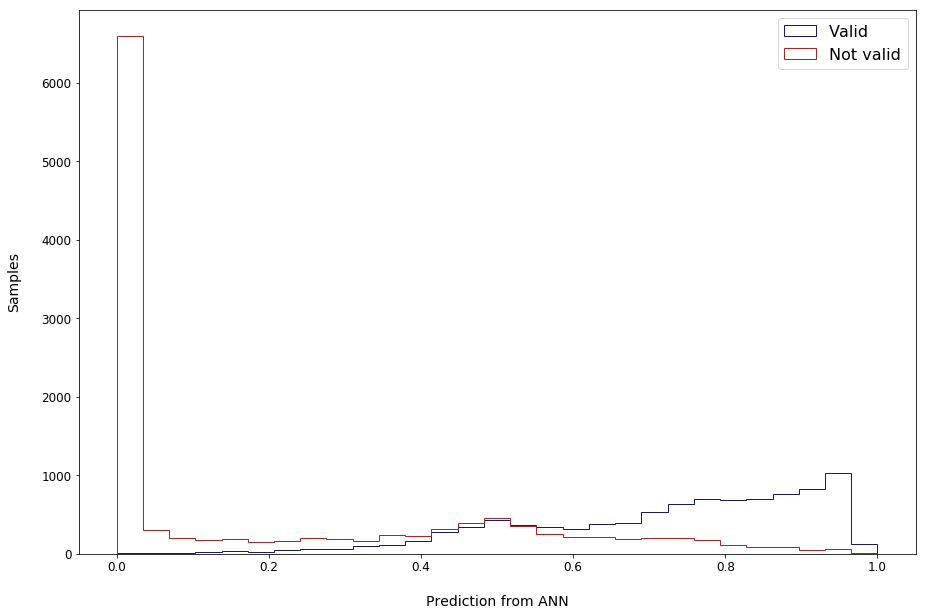

In [83]:
#xgb.plot_importance(booster,grid=True);

fig = plt.figure(figsize=(15,10));
plt.hist(predictions[y_test.reshape(-1).astype(bool)],bins=np.linspace(0,1,30),
         histtype='step',color='midnightblue',label='Valid');
plt.hist(predictions[~(y_test.reshape(-1).astype(bool))],bins=np.linspace(0,1,30),
         histtype='step',color='firebrick',label='Not valid');
# make the plot readable
plt.xlabel('\nPrediction from ANN',fontsize=14);
plt.ylabel('Samples\n',fontsize=14);
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.legend(loc = 'upper right',prop={'size': 16})

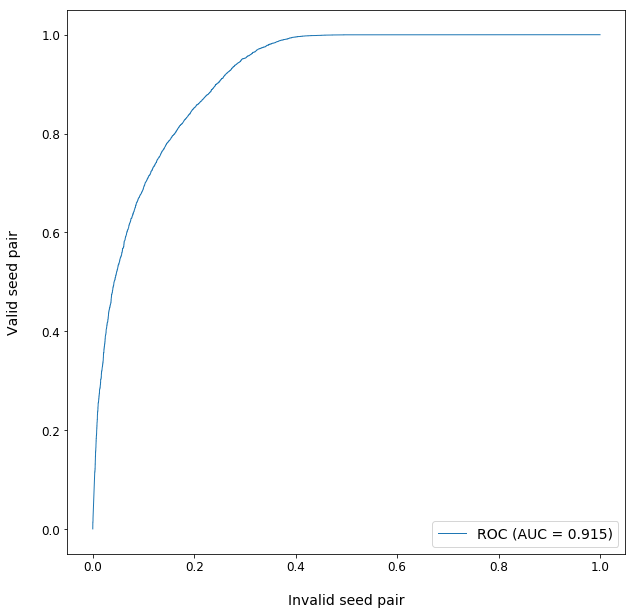

In [85]:
fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(10,10))                                        
plt.plot(fpr, tpr, lw=1, alpha=1, label='ROC (AUC = %0.3f)' % (roc_auc))
plt.xlabel('\nInvalid seed pair', fontsize=14)
plt.ylabel('Valid seed pair\n', fontsize=14)
plt.legend(loc = 'lower right',prop={'size': 14})
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.show()

In [20]:
from keras.utils import plot_model
plot_model(track_classifier, to_file='model.png', show_shapes=True, show_layer_names=False)

In [48]:
track_classifier.save("./models/two_seeds_validation.h5")